**извлечение признаков из текста на естественном языке**

классификатор текстов HashingVectorizer

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

/usr/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'0.23.2'

## тексты

In [4]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(5)

записей: 3196


,text,tag
815,"Мужской череп и оккупационные паспорта. Репортаж из Мядельского музея народной славы\n\n3 декабря 2016 в 9:00\n\nКсения Тарасевич, TUT.BY\n\nПроект «Музеи Беларуси вместе с БЕЛКАРТ» приглашает вир...",culture
1962,"Избранный президент США Дональд Трамп назван «человеком года» по версии деловой газеты Financial Times.\n\n«Он переписал правила политики США. Теперь президент, являющийся специалистом по заключен...",politics
2853,"Телеканал «Пятница» (входит в холдинг «Газпром-медиа») сообщил, что подал иск о защите репутации к «десяткам» пользователей социальной сети Facebook. Претензии канала связаны с обсуждением в этой ...",incident
1290,"YouTube рассказал, что смотрели белорусы в 2016 году\n\n8 декабря 2016 в 11:15\n\n42.TUT.BY\n\nКомпания Google представила YouTube Rewind 2016 — рейтинг самых популярных видео и музыкальных клипов...",social
2150,"Читайте также:\n\n22:46 Разное. Производитель емкостей для допинг-проб: мы хотим оставаться впереди тех, кто обманывает, но вы не можете избежать системы, созданной русскими 1137\n\n22:27 Гандбол....",sport


## токенизация и очистка

In [5]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def text_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'\d+',' '] # удаляем цифры
       ,[r'[\W]+',' '] # удаляем спец.символы
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenize(s): 
    return [ w for w in s.split() if (len(w)>1) ]

In [6]:
data['ctext'] = data['text'].progress_apply(text_normalizer)
data['ctext'] = data['ctext'].progress_apply( tokenize )

100%|██████████| 3196/3196 [00:00<00:00, 32729.28it/s]


In [7]:
# собираем словарь
vcb = [ set(s) for s in data['ctext'].tolist() ]
vcb = sorted(set.union(*vcb))
print('словарь %i слов'%(len(vcb)))
# pd.DataFrame( vcb0 ).to_csv('voc0.txt',index=False,header=False)

словарь 81942 слов


In [8]:
data.sample(5)

,text,tag,ctext
2528,"Запуск был отложен из-за того, что компания продолжает работу над изменением системы заправки топливом ракеты Falcon 9, которая взорвалась в сентябре\n\n«Мы тщательно оцениваем наши конструкции, с...",science,"[запуск, был, отложен, из, за, того, что, компания, продолжает, работу, над, изменением, системы, заправки, топливом, ракеты, falcon, которая, взорвалась, сентябре, мы, тщательно, оцениваем, наши,..."
1958,"Об этом говорится в выпуске британской деловой газеты во вторник, 13 декабря. Financial Times считает, что миллиардер переписал правила политики своей страны.\n\nТеперь президент, являющийся специ...",politics,"[об, этом, говорится, выпуске, британской, деловой, газеты, во, вторник, декабря, financial, times, считает, что, миллиардер, переписал, правила, политики, своей, страны, теперь, президент, являющ..."
1825,"Иран и Россия заключили меморандум о сотрудничестве в области нефти, который включает 22 пункта. Документ подписали замглавы Минэнерго РФ Кирилл Молодцов и замминистра нефти Ирана Амир Хосейн Зама...",economics,"[иран, россия, заключили, меморандум, сотрудничестве, области, нефти, который, включает, пункта, документ, подписали, замглавы, минэнерго, рф, кирилл, молодцов, замминистра, нефти, ирана, амир, хо..."
675,"""Красный пищевик"" выпустил идеальные новогодние подарки\n\n28 ноября 2016 в 9:00\n\n*На правах рекламы\n\nПразднование Нового года ассоциируется у нас с хорошими и радостными моментами. Преднового...",reclama,"[красный, пищевик, выпустил, идеальные, новогодние, подарки, ноября, на, правах, рекламы, празднование, нового, года, ассоциируется, нас, хорошими, радостными, моментами, предновогодняя, суета, ук..."
1250,Во Франции нашли спрятанные под землей автомобили 1930-х\n\n30 ноября 2016 в 12:13\n\nmotor.ru\n\nБельгийский исследователь обнаружил в подземной каменоломне во Франции десятки автомобилей 1930-х ...,auto,"[во, франции, нашли, спрятанные, под, землей, автомобили, ноября, motor, ru, бельгийский, исследователь, обнаружил, подземной, каменоломне, во, франции, десятки, автомобилей, годов, выпуска, как, ..."


## Vectorizer

In [9]:
data['ctext'] = data['ctext'].apply( ' '.join  )

In [10]:
tf = HashingVectorizer( n_features=4096, norm='l2' ).fit( data['ctext'] )

## формируем датасеты

In [11]:
X = tf.transform( data['ctext'] )
X.shape

(3196, 4096)

In [12]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [13]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 4096), (2237,), (959, 4096), (959,))

## обучаем классификатор

In [15]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [16]:
o = clf.predict(X_train)

In [17]:
accuracy_score(y_train,o)

0.9995529727313366

In [18]:
o = clf.predict(X_test)

In [19]:
accuracy_score(y_test,o)

0.835245046923879

In [20]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.97      0.86      0.91        87
           1       0.77      0.85      0.81       101
           2       0.80      0.74      0.77        76
           3       0.78      0.58      0.67        31
           4       0.86      0.93      0.89       123
           5       0.87      0.92      0.89       177
           6       0.71      0.57      0.63        21
           7       0.75      0.71      0.73        17
           8       0.87      0.97      0.92        68
           9       0.54      0.30      0.38        44
          10       0.93      0.97      0.95       118
          11       0.72      0.73      0.73        89
          12       0.54      1.00      0.70         7

    accuracy                           0.84       959
   macro avg       0.78      0.78      0.77       959
weighted avg       0.83      0.84      0.83       959



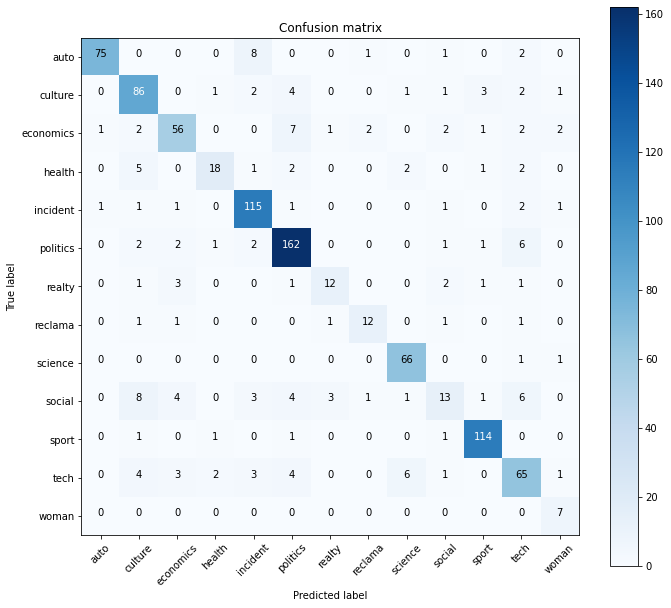

In [21]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [22]:
o = clf.predict(X)

In [23]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [24]:
for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: sport
predict: sport
(обновлено 00:51 13.12.2016 ) МОСКВА, 13 дек - Р-Спорт. "Вильярреал" одержал домашнюю победу над мадридским "Атлетико" в матче 15-го тура чемпионата Испании по футболу. Встреча, прошедшая в понедель...
- - - - - - - - - - - - - - - - - -
tag: politics
predict: politics
Заявления о возможной российской угрозе странно слышать от властей Хорватии, однако Москва готова обсудить данные аргументы Загреба, заявил российский министр иностранных дел Сергей Лавров в интервью ...
- - - - - - - - - - - - - - - - - -
tag: health
predict: health
ЖК-мониторы вредны для глаз Однако проблема заключается вовсе не в
электромагнитном излучении, а в особенностях строения зрительного аппарата
человека.При максимальном напряжении зрения частота морган...
- - - - - - - - - - - - - - - - - -
tag: auto
predict: auto
«Горячий» хэтчбек Suzuki Baleno RS дебютирует на авторынке Индии в первой половине 2017 года. В компании-производителе Maruti Suzuki, «дочка» бренда Suzuki, не исключают во